In [ ]:
import pandas as pd

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

In [ ]:
pd.reset_option('display.max_colwidth')
pd.reset_option('display.max_rows')

In [ ]:
# =============================================
# Complete pipeline up to XGBoost feature preparation
# NFCorpus (BEIR) - BM25 + BERT reranker features
# Runs in free Colab (~5-15 min depending on GPU/CPU)
# =============================================

# 0. Installs
!pip install -q ir_datasets rank_bm25 sentence-transformers xgboost ir_measures

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.1/866.1 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.0/149.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.8/304.8 kB 12.7 MB/s eta 0:00:00


In [ ]:
import ir_datasets
from rank_bm25 import BM25Okapi
from sentence_transformers import CrossEncoder
import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import torch
import random

In [ ]:
# ========================
# 0. Load NFCorpus (train for index, test for evaluation prep)
# ========================
print("Loading NFCorpus...")
dataset_train = ir_datasets.load("beir/nfcorpus/train")
dataset_test  = ir_datasets.load("beir/nfcorpus/test")

# Corpus is the same across splits — we use full corpus text
all_docs = list(ir_datasets.load("beir/nfcorpus").docs_iter())  # or train.docs_iter()
doc_id_to_text = {doc.doc_id: doc.text for doc in all_docs}
doc_ids = list(doc_id_to_text.keys())

print(f"Corpus size: {len(doc_ids)} documents")

[INFO] [starting] building docstore


Loading NFCorpus...


[INFO] [starting] opening zip file
[INFO] [starting] https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/nfcorpus.zip
docs_iter:   0%|                                      | 0/3633 [00:01<?, ?doc/s]
https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/nfcorpus.zip: 0.0%| 0.00/2.45M [00:00<?, ?B/s]
https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/nfcorpus.zip: 1.3%| 32.8k/2.45M [00:00<00:10, 232kB/s]
https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/nfcorpus.zip: 3.3%| 81.9k/2.45M [00:00<00:08, 284kB/s]
https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/nfcorpus.zip: 8.0%| 197k/2.45M [00:00<00:05, 450kB/s] 
https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/nfcorpus.zip: 16.7%| 410k/2.45M [00:00<00:02, 704kB/s]
https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/nfcorpus.zip: 31.5%| 770k/2.45M [00:00<00:01, 1.06MB/s]

[INFO] [finished] https://public.ukp.informatik.tu-darmstadt

Corpus size: 3633 documents


## Data Exploration

In [ ]:
from itertools import islice

print("==============================\n")
print("Documents:\n")
for doc in islice(dataset_train.docs_iter(), 5):
    print(doc)
    print()

print("==============================\n")
print("Queries:\n")
for q in islice(dataset_train.queries_iter(), 5):
    print(q)

print("==============================\n")
print("Qrels:\n")
for qrel in islice(dataset_train.qrels_iter(), 5):
    print(qrel)


Documents:

BeirTitleUrlDoc(doc_id='MED-10', text='Recent studies have suggested that statins, an established drug group in the prevention of cardiovascular mortality, could delay or prevent breast cancer recurrence but the effect on disease-specific mortality remains unclear. We evaluated risk of breast cancer death among statin users in a population-based cohort of breast cancer patients. The study cohort included all newly diagnosed breast cancer patients in Finland during 1995–2003 (31,236 cases), identified from the Finnish Cancer Registry. Information on statin use before and after the diagnosis was obtained from a national prescription database. We used the Cox proportional hazards regression method to estimate mortality among statin users with statin use as time-dependent variable. A total of 4,151 participants had used statins. During the median follow-up of 3.25 years after the diagnosis (range 0.08–9.0 years) 6,011 participants died, of which 3,619 (60.2%) was due to breast

In [ ]:
# ========================
# Docs Check
# ========================

print("Total docs:", len(doc_id_to_text))

missing = sum(1 for t in doc_id_to_text.values() if t is None)
empty = sum(1 for t in doc_id_to_text.values() if t and not t.strip())

print("Missing text:", missing)
print("Empty text:", empty)

doc_ids = list(doc_id_to_text.keys())
print("Duplicate doc IDs:", len(doc_ids) - len(set(doc_ids)))

texts = list(doc_id_to_text.values())
print("Duplicate texts:", len(texts) - len(set(texts)))

lengths = [len(t.split()) for t in doc_id_to_text.values()]
print("Avg doc length:", sum(lengths)/len(lengths))

Total docs: 3633
Missing text: 0
Empty text: 0
Duplicate doc IDs: 0
Duplicate texts: 40
Avg doc length: 220.97880539499036


In [ ]:
# ========================
# Query Check
# ========================
train_queries = {q.query_id: q.text for q in dataset_train.queries_iter()}
test_queries  = {q.query_id: q.text for q in dataset_test.queries_iter()}

print("Train queries:", len(train_queries))
print("Test queries:", len(test_queries))

missing_train = sum(1 for t in train_queries.values() if t is None)
empty_train   = sum(1 for t in train_queries.values() if t and not t.strip())

print("Train missing queries:", missing_train)
print("Train empty queries:", empty_train)

missing_test = sum(1 for t in test_queries.values() if t is None)
empty_test   = sum(1 for t in test_queries.values() if t and not t.strip())

print("Test missing queries:", missing_test)
print("Test empty queries:", empty_test)

Train queries: 2590
Test queries: 323
Train missing queries: 0
Train empty queries: 0
Test missing queries: 0
Test empty queries: 0


[INFO] [starting] opening zip file
[INFO] [finished] opening zip file s]


In [ ]:
def analyze_query_lengths(queries_dict):
    lengths = {qid: len(text.split()) for qid, text in queries_dict.items()}

    too_short = [qid for qid, l in lengths.items() if l < 3]
    too_long  = [qid for qid, l in lengths.items() if l > 60]

    print("Total queries:", len(lengths))
    print("Too short (<3 words):", len(too_short))
    print("Too long (>60 words):", len(too_long))

    return too_short, too_long, lengths

train_short, train_long, train_lengths = analyze_query_lengths(train_queries)
test_short, test_long, test_lengths = analyze_query_lengths(test_queries)

print("\nExample short queries:")
for qid in train_short[:5]:
    print(qid, "->", train_queries[qid])

print("\nExample long queries:")
for qid in train_long[:5]:
    print(qid, "->", train_queries[qid][:200])

Total queries: 2590
Too short (<3 words): 1362
Too long (>60 words): 0
Total queries: 323
Too short (<3 words): 172
Too long (>60 words): 0

Example short queries:
PLAIN-172 -> Tarragon Toxicity?
PLAIN-173 -> Nutmeg Toxicity
PLAIN-328 -> Bad Egg
PLAIN-470 -> 5-alpha pregnanedione
PLAIN-471 -> A/V ratio

Example long queries:


In [ ]:
# ========================
# Qrels Check
# ========================

train_qrels = list(dataset_train.qrels_iter())
test_qrels  = list(dataset_test.qrels_iter())

invalid_train_queries = [
    q.query_id for q in train_qrels
    if q.query_id not in train_queries
]
print("Train qrels with invalid query IDs:", len(invalid_train_queries))

invalid_test_queries = [
    q.query_id for q in test_qrels
    if q.query_id not in test_queries
]
print("Test qrels with invalid query IDs:", len(invalid_test_queries))

doc_ids_set = set(doc_ids)
invalid_train_docs = [
    q.doc_id for q in train_qrels
    if q.doc_id not in doc_ids_set
]
print("Train qrels with invalid doc IDs:", len(invalid_train_docs))

invalid_test_docs = [
    q.doc_id for q in test_qrels
    if q.doc_id not in doc_ids_set
]
print("Test qrels with invalid doc IDs:", len(invalid_test_docs))

Train qrels with invalid query IDs: 0
Test qrels with invalid query IDs: 0
Train qrels with invalid doc IDs: 0
Test qrels with invalid doc IDs: 0


In [ ]:
import pandas as pd
import random
from itertools import islice
from IPython.display import display, Markdown

# =========================
# Load samples into DataFrames
# =========================

# Docs (limit for speed)
docs = list(ir_datasets.load("beir/nfcorpus").docs_iter())
docs_df = pd.DataFrame([{
    "doc_id": d.doc_id,
    "text": d.text
} for d in docs])

# Queries
queries = list(ir_datasets.load("beir/nfcorpus/train").queries_iter())
queries_df = pd.DataFrame([{
    "query_id": q.query_id,
    "query": q.text
} for q in queries])

# Qrels
qrels = list(ir_datasets.load("beir/nfcorpus/train").qrels_iter())
qrels_df = pd.DataFrame([{
    "query_id": r.query_id,
    "doc_id": r.doc_id,
    "rel": r.relevance
} for r in qrels])

# =========================
# Dataset overview
# =========================

print("Dataset Overview")

print("Total docs:", len(docs_df))
print("Total queries:", len(queries_df))
print("Total qrels:", len(qrels_df))

Dataset Overview
Total docs: 3633
Total queries: 2590
Total qrels: 110575


In [ ]:
# =========================
# Random Docs Preview
# =========================

print("Random Document Samples\n")
print(docs_df.sample(5).assign(
    text=lambda df: df["text"].str[:300])
)

Random Document Samples

        doc_id  \
957   MED-1929   
473   MED-1342   
2662  MED-4309   
1481  MED-2599   
1540  MED-2703   

                                                                                                                                                                                                                                                                                                              text  
957   BACKGROUND This study examined the effects of brief daily yogic meditation on mental health, cognitive functioning, and immune cell telomerase activity in family dementia caregivers with mild depressive symptoms. METHODS Thirty-nine family dementia caregivers (mean age 60.3 years old (SD=10.2)) were  
473   Background Previous meta-analyses of published and unpublished trials indicate that antidepressants provide modest benefits compared to placebo in the treatment of depression; some have argued that these benefits are not clinically significan

In [ ]:
# =========================
# Random Query Explorer
# =========================

print("Random Query Explorer\n")

sample_q = queries_df.sample(1).iloc[0]
print("Query ID:", sample_q.query_id)
print("Query Text:", sample_q.query)

# Relevant docs
rel_docs = qrels_df[qrels_df.query_id == sample_q.query_id].merge(
    docs_df, on="doc_id", how="left"
)

print(f"\nRelevant Documents ({len(rel_docs)})")
print(rel_docs.head(5)[["doc_id", "rel", "text"]].assign(
    text=lambda df: df["text"].str[:300]
))

Random Query Explorer

Query ID: PLAIN-3248
Query Text: Raw Food Nutrient Absorption

Relevant Documents (39)
     doc_id  rel  \
0  MED-4858    1   
1  MED-1789    1   
2  MED-1790    1   
3  MED-1791    1   
4  MED-1792    1   

                                                                                                                                                                                                                                                                                                           text  
0  BACKGROUND/OBJECTIVE: beta-Carotene is often used as a marker for the amount of fruit and vegetables consumed, but little is known about plasma beta-carotene concentrations in subjects whose habitual (long-term) diets are characterized by different amounts of foods of plant origin. We compared dieta  
1  SCOPE: Dietary polyphenols (PP) can be divided into two groups: extractable polyphenols (EPP) or compounds solubilized by aqueous organic solvents, and no

In [ ]:
from collections import defaultdict
import matplotlib.pyplot as plt

# Count relevant docs per query
qrels_per_query = defaultdict(int)

for qrel in dataset_train.qrels_iter():
    qrels_per_query[qrel.query_id] += 1
counts = list(qrels_per_query.values())

print(f"Number of queries: {len(counts)}")
print("Min relevant docs per query:", np.min(counts))
print("Max relevant docs per query:", np.max(counts))
print("Mean relevant docs per query:", np.mean(counts))
print("Median relevant docs per query:", np.median(counts))
queries_with_1_rel = sum(1 for c in counts if c == 1)
print("Queries with only 1 relevant doc:", queries_with_1_rel)

Number of queries: 2590
Min relevant docs per query: 1
Max relevant docs per query: 1363
Mean relevant docs per query: 42.69305019305019
Median relevant docs per query: 18.0
Queries with only 1 relevant doc: 188


Loading BEIR NFCorpus TRAIN split...
Raw: 2590 queries with qrels

Original distribution:
  Total queries with qrels: 2590
  Min / Max rel docs:       1 / 1363
  Mean / Median:            42.7 / 18.0
  Queries with < 5 rel:     545
  Queries with >50 rel:     483


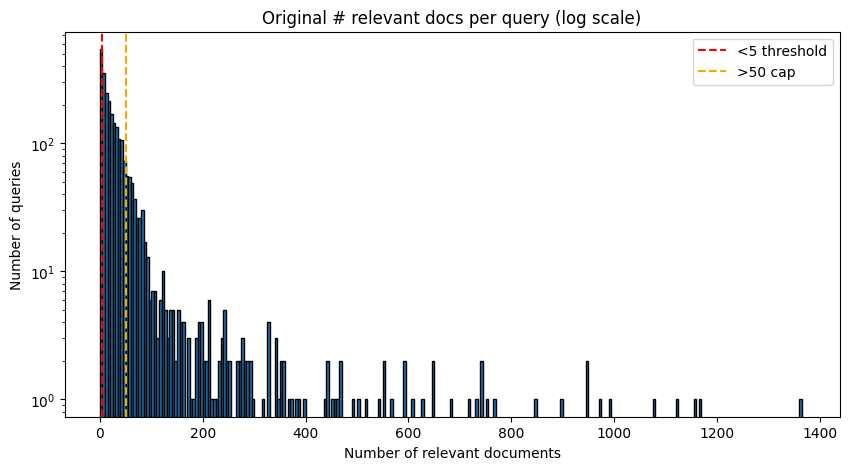


After filtering:
  Queries kept (≥ 5 rel docs):     2045
  Queries removed (< 5):           545
  Queries that were downsampled:          335
  New min / max / mean / median:         5 / 64 / 30.9 / 26.0


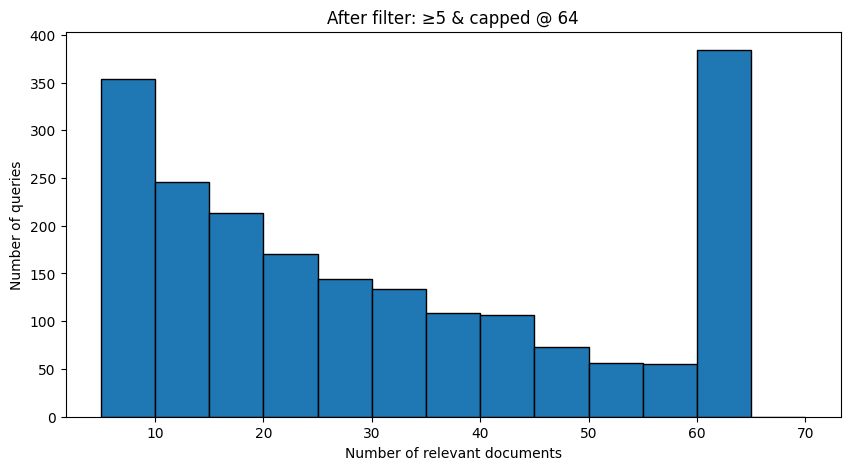

In [ ]:
import ir_datasets
from collections import defaultdict
import random
import numpy as np
import matplotlib.pyplot as plt

# ────────────────────────────────────────────────
# 1. Load TRAIN split (this is where most qrels live)
# ────────────────────────────────────────────────
print("Loading BEIR NFCorpus TRAIN split...")
dataset = ir_datasets.load("beir/nfcorpus/train")

# Build query → list of relevant doc_ids
qrels_dict = defaultdict(list)
for qrel in dataset.qrels_iter():
    qrels_dict[qrel.query_id].append(qrel.doc_id)

print(f"Raw: {len(qrels_dict)} queries with qrels")

# ────────────────────────────────────────────────
# 2. Compute counts & show original distribution
# ────────────────────────────────────────────────
rel_counts = {qid: len(docs) for qid, docs in qrels_dict.items()}
counts = np.array(list(rel_counts.values()))

print("\nOriginal distribution:")
print(f"  Total queries with qrels: {len(rel_counts)}")
print(f"  Min / Max rel docs:       {counts.min()} / {counts.max()}")
print(f"  Mean / Median:            {counts.mean():.1f} / {np.median(counts):.1f}")
print(f"  Queries with < 5 rel:     {sum(counts < 5)}")
print(f"  Queries with >50 rel:     {sum(counts > 50)}")

# Quick histogram
plt.figure(figsize=(10,5))
plt.hist(counts, bins=range(0, max(101, counts.max()+10), 5), edgecolor='black', log=True)
plt.title("Original # relevant docs per query (log scale)")
plt.xlabel("Number of relevant documents")
plt.ylabel("Number of queries")
plt.axvline(5, color='red', linestyle='--', label="<5 threshold")
plt.axvline(50, color='orange', linestyle='--', label=">50 cap")
plt.legend()
plt.show()

# ────────────────────────────────────────────────
# 3. Apply your desired filtering
# ────────────────────────────────────────────────
MIN_REL = 5
MAX_REL = 64

valid_qids = {qid for qid, cnt in rel_counts.items() if cnt >= MIN_REL}

filtered_qrels = {}
downsampled_count = 0

random.seed(42)  # reproducible

for qid in valid_qids:
    docs = qrels_dict[qid]
    if len(docs) > MAX_REL:
        docs = random.sample(docs, MAX_REL)
        downsampled_count += 1
    filtered_qrels[qid] = docs

# ────────────────────────────────────────────────
# 4. Report results
# ────────────────────────────────────────────────
print("\nAfter filtering:")
print(f"  Queries kept (≥ {MIN_REL} rel docs):     {len(filtered_qrels)}")
print(f"  Queries removed (< {MIN_REL}):           {len(qrels_dict) - len(filtered_qrels)}")
print(f"  Queries that were downsampled:          {downsampled_count}")

after_counts = np.array([len(d) for d in filtered_qrels.values()])
print(f"  New min / max / mean / median:         {after_counts.min()} / {after_counts.max()} / {after_counts.mean():.1f} / {np.median(after_counts):.1f}")

# Final histogram
plt.figure(figsize=(10,5))
plt.hist(after_counts, bins=range(MIN_REL, MAX_REL+11, 5), edgecolor='black')
plt.title(f"After filter: ≥{MIN_REL} & capped @ {MAX_REL}")
plt.xlabel("Number of relevant documents")
plt.ylabel("Number of queries")
plt.show()

In [ ]:
# ========================
# 0. Load NFCorpus (train for index, test for evaluation prep)
# ========================
print("Loading NFCorpus...")
dataset_train = ir_datasets.load("beir/nfcorpus/train")
dataset_test  = ir_datasets.load("beir/nfcorpus/test")

# Corpus is the same across splits — we use full corpus text
all_docs = list(ir_datasets.load("beir/nfcorpus").docs_iter())
doc_id_to_text = {doc.doc_id: doc.text for doc in all_docs}
doc_ids = list(doc_id_to_text.keys())

print(f"Corpus size: {len(doc_ids)} documents")

Loading NFCorpus...
Corpus size: 3633 documents


In [ ]:
# ───────────────────────────────────────────────────────────────
# Filter Qrels
# ───────────────────────────────────────────────────────────────

# 1. Build qrels_dict for TRAIN
train_qrels_dict = defaultdict(list)
for qrel in dataset_train.qrels_iter():
    train_qrels_dict[qrel.query_id].append(qrel.doc_id)

# 2. Apply your filtering
MIN_REL = 5
MAX_REL = 64
random.seed(42)

valid_train_qids = {
    qid for qid, docs in train_qrels_dict.items()
    if MIN_REL <= len(docs)
}

filtered_train_qrels = {}
downsampled = 0

for qid in valid_train_qids:
    docs = train_qrels_dict[qid]
    if len(docs) > MAX_REL:
        docs = random.sample(docs, MAX_REL)
        downsampled += 1
    filtered_train_qrels[qid] = set(docs)   # set for fast .in check later

print(f"Kept {len(filtered_train_qrels)} out of {len(train_qrels_dict)} train queries")
print(f"Downsampled {downsampled} queries to {MAX_REL} positives")


Kept 2045 out of 2590 train queries
Downsampled 335 queries to 64 positives


In [ ]:
# ========================
# 0. Load NFCorpus (train for index, test for evaluation prep)
# ========================
print("Loading NFCorpus...")
dataset_train = ir_datasets.load("beir/nfcorpus/train")
dataset_test  = ir_datasets.load("beir/nfcorpus/test")

# Corpus is the same across splits — we use full corpus text
all_docs = list(ir_datasets.load("beir/nfcorpus").docs_iter())  # or train.docs_iter()
doc_id_to_text = {doc.doc_id: doc.text for doc in all_docs}
doc_ids = list(doc_id_to_text.keys())

print(f"Corpus size: {len(doc_ids)} documents")

# ========================
# 1. Build BM25 index
# ========================
print("Building BM25 index...")
tokenized_corpus = [doc.text.lower().split() for doc in tqdm(all_docs, desc="Tokenizing corpus")]
bm25 = BM25Okapi(tokenized_corpus)

print("BM25 index ready.")

# ========================
# 2. Load fast Cross-Encoder reranker
# ========================
print("Loading Cross-Encoder reranker...")
reranker = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2', device='cuda')  # use 'cpu' if no GPU
print("Reranker loaded.")

# ========================
# 3. For each test query → BM25 top-100 → BERT scores → build features
# ========================

# We will collect ALL rows across all queries
feature_rows = []
qid_list = []           # for XGBoost group (query id repeated for each candidate)
relevance_list = []     # ground truth labels

# Map query_id → relevance dict for fast lookup
qrels_dict = {}

for qrel in dataset_train.qrels_iter():
    qid = qrel.query_id
    did = qrel.doc_id
    rel = qrel.relevance
    if qid not in qrels_dict:
        qrels_dict[qid] = {}
    qrels_dict[qid][did] = rel

train_queries = list(dataset_train.queries_iter())

print(f"Processing {len(train_queries)} train queries...")

for query in tqdm(train_queries, desc="Processing queries"):
    qid = query.query_id
    qtext = query.text

    # 3.1 BM25 retrieve top-100
    tokenized_query = qtext.lower().split()
    bm25_scores = bm25.get_scores(tokenized_query)

    # Get top-100 doc indices & scores
    top_idx = np.argsort(bm25_scores)[::-1][:300]
    top_doc_ids = [doc_ids[i] for i in top_idx]
    top_bm25_scores = bm25_scores[top_idx]

    # Normalize BM25 scores a bit (optional but helps)
    if len(top_bm25_scores) > 0:
        top_bm25_scores = (top_bm25_scores - top_bm25_scores.min()) / (top_bm25_scores.max() - top_bm25_scores.min() + 1e-8)

    # 3.2 Prepare pairs for cross-encoder
    pairs = [[qtext, doc_id_to_text[did]] for did in top_doc_ids]

    # 3.3 Get BERT (cross-encoder) scores
    with torch.no_grad():
        bert_scores = reranker.predict(pairs, batch_size=32, show_progress_bar=False)

    # 3.4 Build features for each candidate
    for rank_in_top, did in enumerate(top_doc_ids):
        bm25_score = top_bm25_scores[rank_in_top]
        bert_score = bert_scores[rank_in_top]

        # Simple extra features (you can add more!)
        doc_len = len(doc_id_to_text[did].split())
        query_len = len(tokenized_query)

        feature_rows.append({
            'qid': qid,
            'doc_id': did,
            'bm25_score': bm25_score,
            'bert_score': bert_score,
            'doc_length': doc_len,
            'query_length': query_len,
            # rank_in_bm25: rank_in_top,   # you can add if you want position bias feature
        })

        # Ground truth label
        rel = qrels_dict.get(qid, {}).get(did, 0)
        relevance_list.append(rel)

    # For XGBoost group sizes
    qid_list.extend([qid] * len(top_doc_ids))

# ========================
# Convert to DataFrames
# ========================

features_df = pd.DataFrame(feature_rows)
features_df['label'] = relevance_list
features_df['group'] = qid_list   # repeated qid for each candidate of the query

print("\nFeature DataFrame ready for XGBoost LTR:")
print(features_df.head(8))
print(f"\nTotal rows (candidates): {len(features_df)}")
print(f"Number of queries: {features_df['qid'].nunique()}")

# Example columns you now have:
# qid, doc_id, bm25_score, bert_score, doc_length, query_length, label, group

Loading NFCorpus...
Corpus size: 3633 documents
Building BM25 index...


Tokenizing corpus: 100%|██████████| 3633/3633 [00:00<00:00, 24095.89it/s]


BM25 index ready.
Loading Cross-Encoder reranker...


Loading weights:   0%|          | 0/105 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: cross-encoder/ms-marco-MiniLM-L-6-v2
Key                          | Status     |  | 
-----------------------------+------------+--+-
bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Reranker loaded.
Processing 2590 train queries...


Processing queries: 100%|██████████| 2590/2590 [1:07:44<00:00,  1.57s/it]



Feature DataFrame ready for XGBoost LTR:
       qid    doc_id  bm25_score  bert_score  doc_length  query_length  label  \
0  PLAIN-3  MED-2427    1.000000   -2.284123         149             6      1   
1  PLAIN-3  MED-2774    0.783629   -5.930433         144             6      0   
2  PLAIN-3  MED-2434    0.718583    2.986796         236             6      1   
3  PLAIN-3  MED-1180    0.605856   -6.064842         238             6      0   
4  PLAIN-3  MED-4465    0.601393   -6.920015         140             6      0   
5  PLAIN-3  MED-3551    0.599772   -5.907237         207             6      0   
6  PLAIN-3  MED-2102    0.592494   -3.955021         209             6      0   
7  PLAIN-3  MED-5087    0.583675   -7.183592         222             6      0   

     group  
0  PLAIN-3  
1  PLAIN-3  
2  PLAIN-3  
3  PLAIN-3  
4  PLAIN-3  
5  PLAIN-3  
6  PLAIN-3  
7  PLAIN-3  

Total rows (candidates): 777000
Number of queries: 2590


In [ ]:
from sklearn.model_selection import GroupShuffleSplit
import numpy as np

# ─── 1. Split by query groups ───
splitter = GroupShuffleSplit(
    n_splits=1,
    test_size=0.2,          # → 80% train / 20% val by number of queries
    random_state=42
)

# groups = qid array (one qid per row/candidate)
train_idx, val_idx = next(splitter.split(
    X=np.arange(len(features_df)),  # dummy X, we only need indices
    groups=features_df['qid'].values
))

# ─── 2. Create train / val dataframes ───
df_train = features_df.iloc[train_idx].copy()
df_val   = features_df.iloc[val_idx].copy()

# Optional: reset index if you want clean indexing
df_train = df_train.reset_index(drop=True)
df_val   = df_val.reset_index(drop=True)

print(f"Train candidates: {len(df_train):,d}  |  Queries: {df_train['qid'].nunique()}")
print(f"  Val candidates: {len(df_val):,d}  |  Queries: {df_val['qid'].nunique()}")


# ─── Prepare validation qrels (only judgments that appear in val set) ───
# This is important — we only evaluate on queries & documents that are in validation
val_qids_set = set(df_val['qid'].unique())

# Extract validation qrels once (from train split!)
val_qrels = []
for qrel in dataset_train.qrels_iter():
    if qrel.query_id in val_qids_set:
        val_qrels.append(ir_measures.Qrel(
            query_id = qrel.query_id,
            doc_id = qrel.doc_id,
            relevance = qrel.relevance,
        ))

print(f"Pre-extracted val qrels: {len(val_qrels)} judgments over {len(val_qids_set)} queries")

# ─── 3. Define the feature column groups you want to compare ───
feature_sets = {
    "BM25_only":   ['bm25_score', 'doc_length', 'query_length'],
    "BERT_only":   ['bert_score', 'doc_length', 'query_length'],
    "Combined":    ['bm25_score', 'bert_score', 'doc_length', 'query_length'],
    # you can add more variants here later
}

# ─── 4. Prepare train / val matrices for each variant ───
X_train_dict = {}
X_val_dict   = {}
y_train = df_train['label'].values.astype(np.float32)
y_val   = df_val['label'].values.astype(np.float32)

group_train = df_train.groupby('qid').size().to_numpy()
group_val   = df_val.groupby('qid').size().to_numpy()

for name, cols in feature_sets.items():
    X_train_dict[name] = df_train[cols].values
    X_val_dict[name]   = df_val[cols].values
    print(f"{name:12} → train shape {X_train_dict[name].shape}, val shape {X_val_dict[name].shape}")

Train candidates: 621,600  |  Queries: 2072
  Val candidates: 155,400  |  Queries: 518
Pre-extracted val qrels: 24551 judgments over 518 queries
BM25_only    → train shape (621600, 3), val shape (155400, 3)
BERT_only    → train shape (621600, 3), val shape (155400, 3)
Combined     → train shape (621600, 4), val shape (155400, 4)


In [ ]:
import xgboost as xgb

params = {
    'objective': 'rank:ndcg',
    'tree_method': 'hist',
    'learning_rate': 0.05,
    'max_depth': 6,
    'n_estimators': 800,
    'random_state': 42,
    'early_stopping_rounds': 40,
    'eval_metric': ['ndcg@10']
}

rankers = {}

for name in feature_sets:
    print(f"\nTraining {name} ...")

    ranker = xgb.XGBRanker(**params)

    ranker.fit(
        X_train_dict[name],
        y_train,
        group=group_train,
        eval_set=[(X_val_dict[name], y_val)],
        eval_group=[group_val],
        verbose=20
    )

    rankers[name] = ranker
    print(f"Best iteration: {ranker.best_iteration}, best ndcg@10: {ranker.best_score:.4f}")


Training BM25_only ...
[0]	validation_0-ndcg@10:0.53531
[20]	validation_0-ndcg@10:0.53893
[40]	validation_0-ndcg@10:0.53761
[60]	validation_0-ndcg@10:0.53834
[62]	validation_0-ndcg@10:0.53773
Best iteration: 22, best ndcg@10: 0.5394

Training BERT_only ...
[0]	validation_0-ndcg@10:0.59937
[20]	validation_0-ndcg@10:0.60272
[40]	validation_0-ndcg@10:0.60153
[60]	validation_0-ndcg@10:0.59913
[68]	validation_0-ndcg@10:0.60000
Best iteration: 28, best ndcg@10: 0.6038

Training Combined ...
[0]	validation_0-ndcg@10:0.59072
[20]	validation_0-ndcg@10:0.59675
[40]	validation_0-ndcg@10:0.59842
[60]	validation_0-ndcg@10:0.59818
[80]	validation_0-ndcg@10:0.59647
[85]	validation_0-ndcg@10:0.59693
Best iteration: 45, best ndcg@10: 0.5996


In [ ]:
# For each ranker
for name, ranker in rankers.items():
    print(f"\nFeature importances for {name}:")

    importance = pd.DataFrame({
        'feature': [f"f{i}" for i in range(ranker.n_features_in_)],
        'importance': ranker.feature_importances_
    }).sort_values('importance', ascending=False)

    # Optional: map back to your real names manually
    real_cols = feature_sets[name]  # your dict of lists
    importance['real_feature'] = importance['feature'].map(
        lambda x: real_cols[int(x[1:])] if x.startswith('f') else x
    )

    print(importance[['real_feature', 'importance']].round(4))


Feature importances for BM25_only:
   real_feature  importance
0    bm25_score      0.9494
2  query_length      0.0343
1    doc_length      0.0164

Feature importances for BERT_only:
   real_feature  importance
0    bert_score      0.9546
2  query_length      0.0298
1    doc_length      0.0157

Feature importances for Combined:
   real_feature  importance
1    bert_score      0.8157
0    bm25_score      0.1491
3  query_length      0.0198
2    doc_length      0.0154


In [ ]:
# =============================================
# Step 5: Evaluate all models on the validation set
# Metrics: NDCG@10
# Variants:
#   - BM25 baseline
#   - BERT reranker (on BM25 top-100)
#   - BM25 + XGBoost
#   - BERT + XGBoost
#   - Combined (BM25 + BERT features) + XGBoost
# =============================================

import ir_measures
from ir_measures import nDCG, R
import pandas as pd
import numpy as np
from collections import defaultdict
from tqdm import tqdm
import torch

# ─── Models & their feature columns ───
models = {
    "BM25":          None,   # special case — no XGBoost
    "BERT_rerank":   None,
    "BM25_XGB":      ['bm25_score', 'doc_length', 'query_length'],
    "BERT_XGB":      ['bert_score', 'doc_length', 'query_length'],
    "Combined_XGB":  ['bm25_score', 'bert_score', 'doc_length', 'query_length'],
}

# Which ranker object to use for each (None = rule-based)
ranker_map = {
    "BM25":          None,
    "BERT_rerank":   None,
    "BM25_XGB":      rankers["BM25_only"],
    "BERT_XGB":      rankers["BERT_only"],
    "Combined_XGB":  rankers["Combined"],
}

# ─── Collect predictions ───
val_qids = set(df_val['qid'].unique())
val_runs = defaultdict(lambda: defaultdict(dict))   # method → qid → docid → score
val_queries = [q for q in dataset_train.queries_iter() if q.query_id in val_qids]

for query in tqdm(val_queries, desc="Scoring validation queries"):
    qid   = query.query_id
    qtext = query.text
    tokenized_query = qtext.lower().split()

    # ─── Retrieve BM25 top-300 ───
    bm25_scores_all = bm25.get_scores(tokenized_query)
    top_idx = np.argsort(bm25_scores_all)[::-1][:300]
    top_doc_ids    = [doc_ids[i] for i in top_idx]
    top_bm25_raw   = bm25_scores_all[top_idx]

    # Normalize (same as training)
    if len(top_bm25_raw) > 1 and top_bm25_raw.max() > top_bm25_raw.min():
        top_bm25 = (top_bm25_raw - top_bm25_raw.min()) / (top_bm25_raw.max() - top_bm25_raw.min() + 1e-8)
    else:
        top_bm25 = top_bm25_raw.astype(float)

    # ─── BERT scores ───
    pairs = [[qtext, doc_id_to_text[did]] for did in top_doc_ids]
    with torch.no_grad():
        bert_scores = reranker.predict(pairs, batch_size=32)

    # ─── Build feature DataFrame ───
    feat_df = pd.DataFrame({
        'bm25_score':   top_bm25,
        'bert_score':   bert_scores,
        'doc_length':   [len(doc_id_to_text[did].split()) for did in top_doc_ids],
        'query_length': len(tokenized_query),
    })

    # ─── Generate scores for each model ───
    for method, cols in models.items():
        if method in ["BM25", "BERT_rerank"]:
            # rule-based
            scores = feat_df['bm25_score'].values if method == "BM25" else feat_df['bert_score'].values
        else:
            # XGBoost model
            X_val_pred = feat_df[cols].values
            scores = ranker_map[method].predict(X_val_pred)

        # Store
        for i, did in enumerate(top_doc_ids):
            val_runs[method][qid][did] = float(scores[i])

Scoring validation queries: 100%|██████████| 518/518 [13:35<00:00,  1.57s/it]


In [ ]:
# ─────────────────────────────────────────────
# Evaluate all runs
# ─────────────────────────────────────────────

metrics = [nDCG@10, R@100]

print("\nValidation results:\n")

for method_name in val_runs:
    flat_run = [
        ir_measures.ScoredDoc(qid, did, score)
        for qid, docs in val_runs[method_name].items()
        for did, score in docs.items()
    ]

    agg_results = ir_measures.calc_aggregate(metrics, val_qrels, flat_run)

    print(f"{method_name:16}", end=" ")
    for m in metrics:
        print(f" {str(m):8} {agg_results[m]:.4f}", end="  ")
    print()


Validation results:

BM25              nDCG@10  0.2630   R@100    0.1988  
BERT_rerank       nDCG@10  0.3099   R@100    0.2192  
BM25_XGB          nDCG@10  0.2643   R@100    0.2011  
BERT_XGB          nDCG@10  0.3114   R@100    0.2196  
Combined_XGB      nDCG@10  0.3092   R@100    0.2190  


In [ ]:
# =============================================
# FINAL EVALUATION ON OFFICIAL TEST SPLIT
# =============================================

import ir_measures
from ir_measures import nDCG, R
from collections import defaultdict
from tqdm import tqdm
import torch
import numpy as np
import pandas as pd

metrics = [nDCG@10, R@100]

print("\n=== Final evaluation on beir/nfcorpus/test ===\n")

test_qrels = list(dataset_test.qrels_iter())
test_queries = list(dataset_test.queries_iter())

for qrel in dataset_test.qrels_iter():
    qid = qrel.query_id
    did = qrel.doc_id
    rel = qrel.relevance  # usually 0/1/2
    if qid not in qrels_dict:
        qrels_dict[qid] = {}
    qrels_dict[qid][did] = rel

test_queries = list(dataset_test.queries_iter())

print(f"Test queries: {len(test_queries)} | Test judgments: {len(test_qrels)}")

# ─── Define models and ranker mapping ───
models = {
    "BM25":          None,
    "BERT_rerank":   None,
    "BM25_XGB":      ['bm25_score', 'doc_length', 'query_length'],
    "BERT_XGB":      ['bert_score', 'doc_length', 'query_length'],
    "Combined_XGB":  ['bm25_score', 'bert_score', 'doc_length', 'query_length'],
}

ranker_map = {
    "BM25":          None,
    "BERT_rerank":   None,
    "BM25_XGB":      rankers.get("BM25_only"),
    "BERT_XGB":      rankers.get("BERT_only"),
    "Combined_XGB":  rankers.get("Combined"),
}

test_runs = defaultdict(lambda: defaultdict(dict))

for query in tqdm(test_queries, desc="Scoring test queries"):
    qid   = query.query_id
    qtext = query.text
    tokenized_query = qtext.lower().split()

    # Retrieve BM25 top-100
    bm25_scores_all = bm25.get_scores(tokenized_query)
    top_idx = np.argsort(bm25_scores_all)[::-1][:300]
    top_doc_ids    = [doc_ids[i] for i in top_idx]
    top_bm25_raw   = bm25_scores_all[top_idx]

    # Normalize
    if len(top_bm25_raw) > 1 and top_bm25_raw.max() > top_bm25_raw.min():
        top_bm25 = (top_bm25_raw - top_bm25_raw.min()) / (top_bm25_raw.max() - top_bm25_raw.min() + 1e-8)
    else:
        top_bm25 = top_bm25_raw.astype(float)

    # BERT scores
    pairs = [[qtext, doc_id_to_text[did]] for did in top_doc_ids]
    with torch.no_grad():
        bert_scores = reranker.predict(pairs, batch_size=32)

    # Features
    feat_df = pd.DataFrame({
        'bm25_score':   top_bm25,
        'bert_score':   bert_scores,
        'doc_length':   [len(doc_id_to_text[did].split()) for did in top_doc_ids],
        'query_length': len(tokenized_query),
    })

    # Score each model
    for method, cols in models.items():
        if method in ["BM25", "BERT_rerank"]:
            scores = feat_df['bm25_score'].values if method == "BM25" else feat_df['bert_score'].values
        else:
            if ranker_map[method] is None:
                continue  # skip if no ranker trained for this variant
            X_test_pred = feat_df[cols].values
            scores = ranker_map[method].predict(X_test_pred)

        for i, did in enumerate(top_doc_ids):
            test_runs[method][qid][did] = float(scores[i])

# ─── Evaluate ───
print("\nTest results:\n")

for method_name in test_runs:
    flat_run = [
        ir_measures.ScoredDoc(qid, did, score)
        for qid, docs in test_runs[method_name].items()
        for did, score in docs.items()
    ]

    if not flat_run:
        print(f"{method_name:16} No predictions generated")
        continue

    agg_results = ir_measures.calc_aggregate(metrics, test_qrels, flat_run)

    print(f"{method_name:16}", end=" ")
    for m in metrics:
        print(f" {str(m):10} {agg_results[m]:.4f}", end="  ")
    print()


=== Final evaluation on beir/nfcorpus/test ===

Test queries: 323 | Test judgments: 12334


Scoring test queries: 100%|██████████| 323/323 [08:28<00:00,  1.58s/it]



Test results:

BM25              nDCG@10    0.2613   R@100      0.2027  
BERT_rerank       nDCG@10    0.3161   R@100      0.2200  
BM25_XGB          nDCG@10    0.2610   R@100      0.2002  
BERT_XGB          nDCG@10    0.3132   R@100      0.2180  
Combined_XGB      nDCG@10    0.3088   R@100      0.2222  


In [ ]:
# ─────────────────────────────────────────────
# Save the models
# ─────────────────────────────────────────────

import pickle
import os

reranker.save_pretrained("saved_models/bert_reranker_ms_marco_mini_lm")
print("BERT reranker saved to: saved_models/bert_reranker_ms_marco_mini_lm")

with open("saved_models/bm25_index.pkl", "wb") as f:
    pickle.dump(bm25, f)
with open("saved_models/corpus_dict.pkl", "wb") as f:
    pickle.dump(doc_id_to_text, f)
print("Baseline BM25 saved.")

rankers["BM25_only"].save_model("saved_models/bm25_xgb.json")
rankers["BERT_only"].save_model("saved_models/bert_xgb.json")
rankers["Combined"].save_model("saved_models/combined_xgb.json")
print("XGBoost model saved.")

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

BERT reranker saved to: saved_models/bert_reranker_ms_marco_mini_lm
Baseline BM25 saved.
XGBoost model saved.


In [ ]:
!zip -r saved_models.zip saved_models

updating: saved_models/ (stored 0%)
updating: saved_models/combined_xgb.json (deflated 75%)
updating: saved_models/corpus_dict.pkl (deflated 66%)
updating: saved_models/bm25_xgb.json (deflated 74%)
updating: saved_models/bert_xgb.json (deflated 75%)
updating: saved_models/bm25_index.pkl (deflated 68%)
updating: saved_models/bert_reranker_ms_marco_mini_lm/ (stored 0%)
updating: saved_models/bert_reranker_ms_marco_mini_lm/config.json (deflated 52%)
updating: saved_models/bert_reranker_ms_marco_mini_lm/model.safetensors (deflated 8%)
updating: saved_models/bert_reranker_ms_marco_mini_lm/tokenizer_config.json (deflated 47%)
updating: saved_models/bert_reranker_ms_marco_mini_lm/tokenizer.json (deflated 71%)
updating: saved_models/bert_reranker_ms_marco_mini_lm/README.md (deflated 58%)


In [ ]:
from google.colab import files
files.download("saved_models.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>